# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,#
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string,
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model,
                                         set_up_input_no_hot_start,
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
#sdl.quantum = False
#sdl.noise = False # noise is for quantum, not classical
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20251012-10-37-11 - 10-37-11


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\five_d.txt.
It is known that the shortest distance is 19


Evaluate cost function and clear cache:

In [ ]:
cost_fn = cost_fn_fact(sdl, distance_array)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda:0


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl.locations, sdl.formulation)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 5 qubits needed for 5 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    hot_start_list = hot_start(distance_array, sdl.locations)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list = hot_start_list_to_string(hot_start_list, 
                                                sdl.locations, 
                                                sdl.gray, 
                                                sdl.formulation,
                                                )
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    sdl.hot_start_dist = float(distance_tensor)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    my_input, unrepeated_input = set_up_input_no_hot_start(sdl, device)

In [9]:
unrepeated_input.size()

torch.Size([1024, 5])

In [10]:
print(unrepeated_input.size())

torch.Size([1024, 5])


Set up model with gradient required:

In [ ]:
model = MyModel(sdl, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 60 parameters in total, of which 60 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

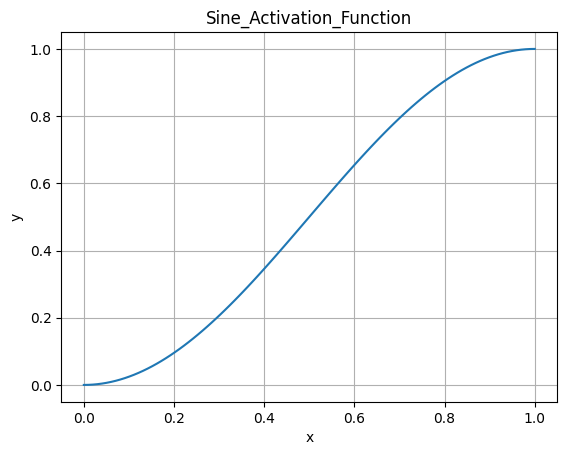

In [13]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[ 0.1788, -0.0388, -0.0825,  0.2010,  0.3102],
        [ 0.4176,  0.1603, -0.2864, -0.0458,  0.3690],
        [-0.0893,  0.2938,  0.2185,  0.0524,  0.2632],
        [ 0.0699, -0.0822, -0.3824, -0.1645, -0.3797],
        [-0.2629,  0.4282,  0.1585, -0.3460,  0.1040]], device='cuda:0',
       requires_grad=True), 'fc1.bias': Parameter containing:
tensor([-0.3906, -0.4399, -0.4157, -0.1087, -0.2398], device='cuda:0',
       requires_grad=True), 'fc2.weight': Parameter containing:
tensor([[ 0.0759, -0.3776,  0.1928, -0.0583,  0.3725],
        [-0.0227,  0.0639,  0.2225, -0.0947, -0.1367],
        [-0.2735,  0.4419,  0.2557,  0.0145,  0.2605],
        [-0.4047,  0.1141, -0.3733, -0.0779,  0.4163],
        [ 0.1497,  0.4399,  0.2831, -0.2338,  0.0930]], device='cuda:0',
       requires_grad=True), 'fc2.bias': Parameter containing:
tensor([-0.0496, -0.3341,  0.0390, -0.2849,  0.2514], device='cuda:0',
       requires_grad=True)}


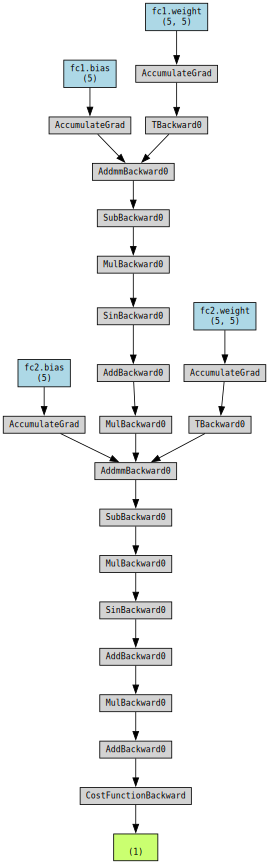

In [14]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 21.000 Epoch min cost:21.000, Lowest Cost to date: 21.000
Epoch 0, fc1.weight grad: 0.00
Epoch 0, fc1.bias grad: 6.29
Epoch 0, fc2.weight grad: 6.63
Epoch 0, fc2.bias grad: 10.11
Epoch 10, Average cost: 23.000 Epoch min cost:23.000, Lowest Cost to date: 21.000
Epoch 10, fc1.weight grad: 0.00
Epoch 10, fc1.bias grad: 3.33
Epoch 10, fc2.weight grad: 5.91
Epoch 10, fc2.bias grad: 6.88
Epoch 20, Average cost: 23.000 Epoch min cost:23.000, Lowest Cost to date: 19.000
Epoch 20, fc1.weight grad: 0.00
Epoch 20, fc1.bias grad: 3.22
Epoch 20, fc2.weight grad: 7.23
Epoch 20, fc2.bias grad: 6.20
Epoch 30, Average cost: 23.000 Epoch min cost:23.000, Lowest Cost to date: 19.000
Epoch 30, fc1.weight grad: 0.00
Epoch 30, fc1.bias grad: 3.05
Epoch 30, fc2.weight grad: 6.49
Epoch 30, fc2.bias grad: 5.35
Epoch 40, Average cost: 19.000 Epoch min cost:19.000, Lowest Cost to date: 19.000
Epoch 40, fc1.weight grad: 0.00
Epoch 40, fc1.bias grad: 0.81
Epoch 40, fc2.weight grad: 5.55
Epoc

In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 19.000 at epoch 11.
The best known cost is 19.000


Plot loss ratio by epoch:

Graph for Run ID: 20251012-10-37-11-10-37-11 being saved to graphs\20251012-10-37-11\10-37-11.png


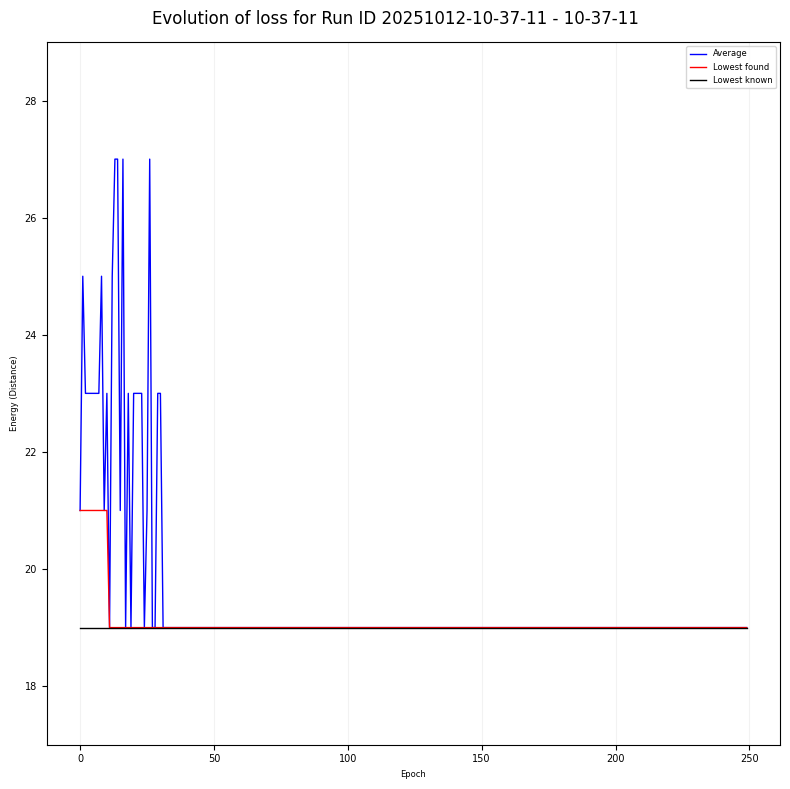

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 0.1785, -0.0387, -0.0824,  0.2007,  0.3097],
        [ 0.4170,  0.1601, -0.2859, -0.0457,  0.3685],
        [-0.0892,  0.2934,  0.2182,  0.0523,  0.2628],
        [ 0.0698, -0.0821, -0.3819, -0.1643, -0.3792],
        [-0.2625,  0.4276,  0.1583, -0.3455,  0.1039]], device='cuda:0',
       requires_grad=True)
bias: Parameter containing:
tensor([-0.0363, -0.7621, -0.1668, -0.0745, -0.6570], device='cuda:0',
       requires_grad=True)
weight: Parameter containing:
tensor([[ 0.0919, -0.3497,  0.2135, -0.0567,  0.3811],
        [-0.0699, -0.1539,  0.1394, -0.0999, -0.2996],
        [-0.1878,  0.5361,  0.3403,  0.0222,  0.2883],
        [-0.2639,  0.4174, -0.1393, -0.0630,  0.5103],
        [ 0.2045,  0.5179,  0.3419, -0.2278,  0.1196]], device='cuda:0',
       requires_grad=True)
bias: Parameter containing:
tensor([ 0.0084, -0.6536,  0.3004,  0.2733,  0.4425], device='cuda:0',
       requires_grad=True)
